Ограничения доступа (permissions) в Django DRF - это механизм, который позволяет ограничивать доступ к определенным ресурсам или действиям в API в зависимости от прав доступа пользователя. 

Для использования ограничений доступа в Django DRF необходимо определить классы, которые будут проверять права доступа пользователя. Классы ограничений доступа должны быть определены в свойстве permission_classes у представлений (views) Django DRF.

Лучшей практикой при использовании ограничений доступа в Django DRF является определение нескольких классов 
ограничений доступа и их комбинирование для обеспечения более гибкой системы управления доступом. Также следует учитывать
что ограничения доступа не заменяют аутентификацию и авторизацию
а лишь дополняют их функциональность.

### Для начала внесем изменения в модель Paper чтобы продемонстрировать что это такое

**models.py**
```python
class Paper(models.Model):
    title = models.CharField(max_length=255)
    slug = models.SlugField(max_length=255, unique=True, db_index=True)
    content = models.TextField(blank=True)
    photo = models.ImageField(upload_to="photos/%Y/%m/%d/", default=None)
    time_create = models.DateTimeField(auto_now_add=True)
    time_update = models.DateTimeField(auto_now=True)
    is_published = models.BooleanField(default=True)
    cat = models.ForeignKey('Categories', on_delete=models.PROTECT, null=True)
```
<a style="color:red">&emsp;&emsp;&emsp;&emsp;user = models.ForeignKey(User, verbose_name='Пользователь', on_delete=models.CASCADE)</a>

<hr>

Поле user будет хранить идентификатор пользователя, который добавил запись которая связана с моделью User где хранятся
все пользователи по умолчанию
verbose_name - то, как это будет отображаться в админке
on_delete - при удалении пользователя будут удалятся все записи, которые связаны с этим пользователем


Далее добавим в views.py следующие классы представления

**views.py**
```python
class PaperAPIList(generics.ListCreateAPIView):
    queryset = Paper.objects.all()
    serializer_class = PaperSerializer


class PaperAPIUpdate(generics.RetrieveUpdateAPIView):
    queryset = Paper.objects.all()
    serializer_class = PaperSerializer


class PaperAPIDestroy(generics.RetrieveDestroyAPIView):
    queryset = Paper.objects.all()
    serializer_class = PaperSerializer
```

**urls.py***
```python
urlpatterns = [
    path('api/v1/paper/', PaperAPIList.as_view(), name="paperapilist"),
    path('api/v1/paper_update/<int:pk>/', PaperAPIUpdate.as_view(), name='paperapiupdate'),
    path('api/v1/paper_delete/<int:pk>/', PaperAPIDestroy.as_view(), name='paperapidestory'),
]
```

Класс PaperAPIList наследуется от generics.ListCreateAPIView и обрабатывает GET и POST запросы. Он возвращает список всех объектов модели Paper при GET запросе, а при POST запросе создает новый объект модели Paper на основе данных, переданных в теле запроса.

Класс PaperAPIUpdate наследуется от generics.RetrieveUpdateAPIView и обрабатывает GET и PUT запросы. Он возвращает объект модели Paper с указанным идентификатором при GET запросе, а при PUT запросе обновляет данные этого объекта на основе данных, переданных в теле запроса.

Класс PaperAPIDestroy наследуется от generics.RetrieveDestroyAPIView и обрабатывает GET и DELETE запросы. Он возвращает объект модели Paper с указанным идентификатором при GET запросе, а при DELETE запросе удаляет этот объект из базы данных.

<hr>

Cейчас любой желающий может поменять, удалить и просматривать статьи на блоге, но мы можем использовать **ограничения доступа**

***Какие есть ограничения доступа в DRF?***
<br>
AllowAny - полный доступ
<br>
IsAuthenticated - только для авторизованных пользователей
<br>
IsAdminUser - только для администраторов
<br>
IsAuthenticatedOrReadOnly - Только для авторизированных или всем но для чтения
#### [Документация](https://www.django-rest-framework.org/api-guide/permissions/)

Добавим

<p style="color:red;">permission_classes = (IsAuthenticated,)</p>
<p style="color:red;">permission_classes = (IsAdminUser,)</p>

```python

from rest_framework.permissions import IsAuthenticated

class PaperAPIList(generics.ListCreateAPIView):
    queryset = Paper.objects.all()
    serializer_class = PaperSerializer
    permission_classes = (IsAuthenticated,)

class PaperAPIDestroy(generics.RetrieveDestroyAPIView):
    queryset = Paper.objects.all()
    serializer_class = PaperSerializer
    permission_classes = (IsAdminUser,)   

```

Если зайти не авторизированным http://127.0.0.1:8000/api/v1/paper/
<br>
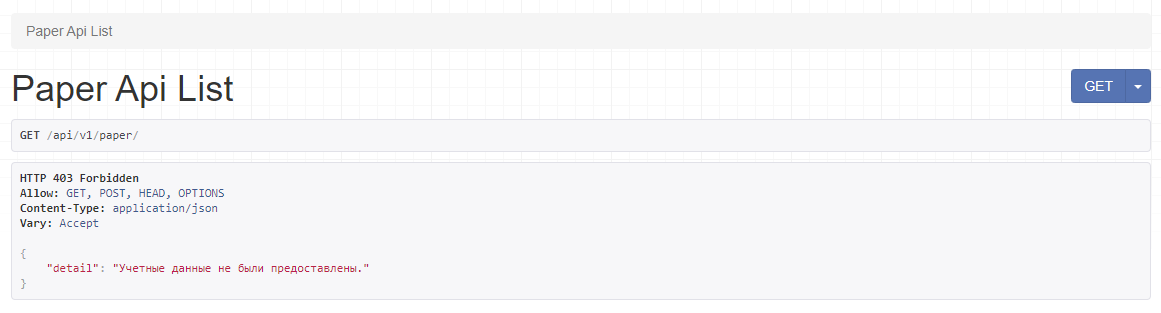

Если зайти без авторизации администратора http://127.0.0.1:8000/api/v1/paper_delete/1/
<br>
(без входа в аккаунт)
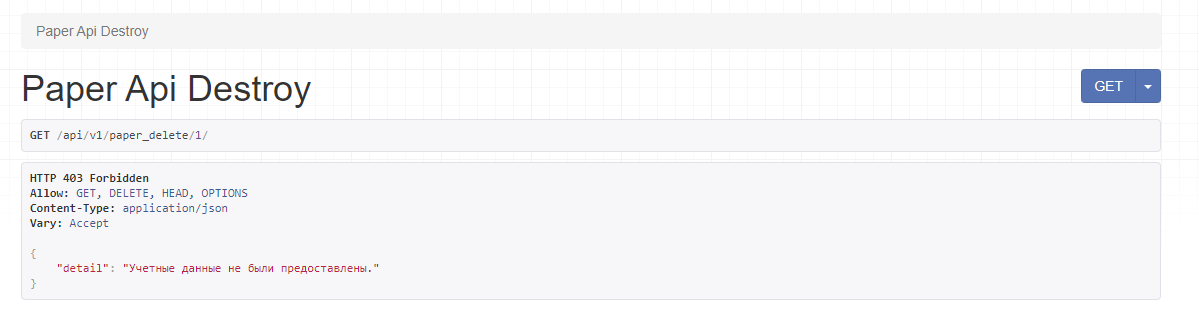
(с входом в аккаунт обычного пользователя)
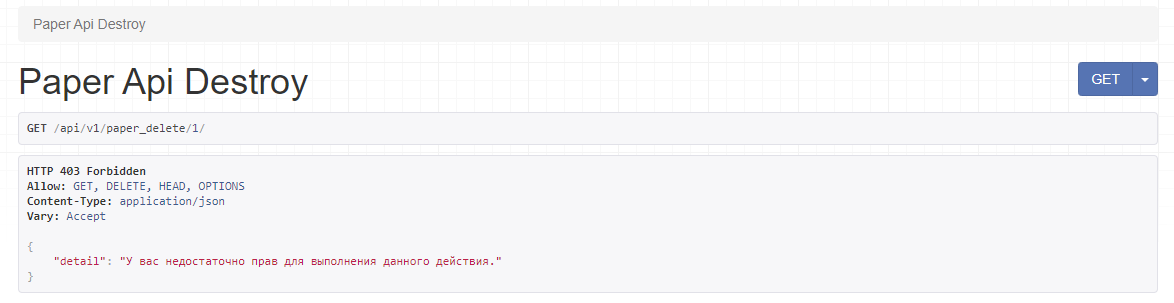

### Как сделать так, чтобы просматривать статью мог каждый, но удалять только администратор?

по умолчанию в django drf нет такого класса, но есть возможность создать его самостоятельно
все ограничения доступа наследуются от базового класса **BasePermission**

```python
class BasePermission(metaclass=BasePermissionMetaclass):
    """
    A base class from which all permission classes should inherit.
    """

    def has_permission(self, request, view): # Настройка прав доступа на уровне всего запроса клиента
        """
        Return `True` if permission is granted, `False` otherwise.
        """
        return True

    def has_object_permission(self, request, view, obj): # Настройка прав доступа на уровне отдельного объекта данных (записи бд)
        """
        Return `True` if permission is granted, `False` otherwise.
        """
        return True
```

Прописываем логику

Создаем файл **permission.py** и записываем
```python
from rest_framework.permissions import BasePermission, SAFE_METHODS

# SAFE_METHODS - запросы на чтение данных SAFE_METHODS = ('GET', 'HEAD', 'OPTIONS')

class IsAdminReadOnly(BasePermission):
    def has_permission(self, request, view):
        if request.method in SAFE_METHODS:
            return True # Указываем что права доступа предоставлены если запрос только на чтение
        # делаем проверку на администратора если запрос не на чтение

        # взято из IsAdminUser
        return bool(request.user and request.user.is_staff)

# original https://www.django-rest-framework.org/api-guide/permissions/#:~:text=class%20IsOwnerOrReadOnly(,request.user
class IsAuthorReadOnly(BasePermission):
    def has_object_permission(self, request, view, obj):
        if request.method in SAFE_METHODS:
            return True
        # если user из базы данных равен user'у который пришел с запроса, то возвращаем True
        return obj.user == request.user
    
```

## Глобальное ограничение доступа для всех разрабатываемых api в рамках drf
Политику разрешений по умолчанию можно установить глобально с помощью DEFAULT_PERMISSION_CLASSES параметра
в settings.py проекта

```python
REST_FRAMEWORK = {
    'DEFAULT_PERMISSION_CLASSES': [
        'rest_framework.permissions.IsAuthenticated', # доступ к данным будет предоставлен только для авторизованных пользователей
    ]
}

# Если не указано, этот параметр по умолчанию разрешает неограниченный доступ:

'DEFAULT_PERMISSION_CLASSES': [
   'rest_framework.permissions.AllowAny',
]
    
```